Here is the data exploring for Walmart dataset from Kaggle. We will use classical models and self-attention model for weekly sales prediction.

1. Load and prepare data

In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [236]:
df = pd.read_csv('data/Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


As we see, the dataset has 8 columns, and we will predict the weekly sales based on the other 7 columns. Let's get familiar with the dataset

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


There are 6435 records in the dataset without null values. Here are some more information about each column.

In [238]:
df.tail(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6425,45,24-08-2012,718232.26,0,72.62,3.834,191.344887,8.684
6426,45,31-08-2012,734297.87,0,75.09,3.867,191.461281,8.684
6427,45,07-09-2012,766512.66,1,75.70,3.911,191.577676,8.684
6428,45,14-09-2012,702238.27,0,67.87,3.948,191.699850,8.684
6429,45,21-09-2012,723086.20,0,65.32,4.038,191.856704,8.684
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667


In [239]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


2. Feature engineering.

Because this is a time series prediction for weekly sales, we will separate the Date column into week, month, year, and season.

In [240]:
df['Date'] = pd.to_datetime(df['Date'], format = '%d-%m-%Y')
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010


We can see that new columns are already added. We will now add season feature.

In [241]:
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    if month in [3, 4, 5]:
        return 0
    if month in [6, 7, 8]:
        return 1
    if month in [9, 10, 11]:
        return 2

df['Season'] = df['Month'].apply(get_season)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,3
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010,3
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010,3
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010,3
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010,0


In [242]:
length = int(len(df) * 0.8)
df['Weekly_Sales'][length: length+100]

5148    536006.73
5149    529852.70
5150    510382.50
5151    513615.82
5152    519255.68
          ...    
5243    527117.81
5244    537224.52
5245    533905.67
5246    605791.46
5247    451327.61
Name: Weekly_Sales, Length: 100, dtype: float64

3. Exploratory Data Analysis

3.1 Univariate Analysis.

We will see in this section how our features and labels are distributed.

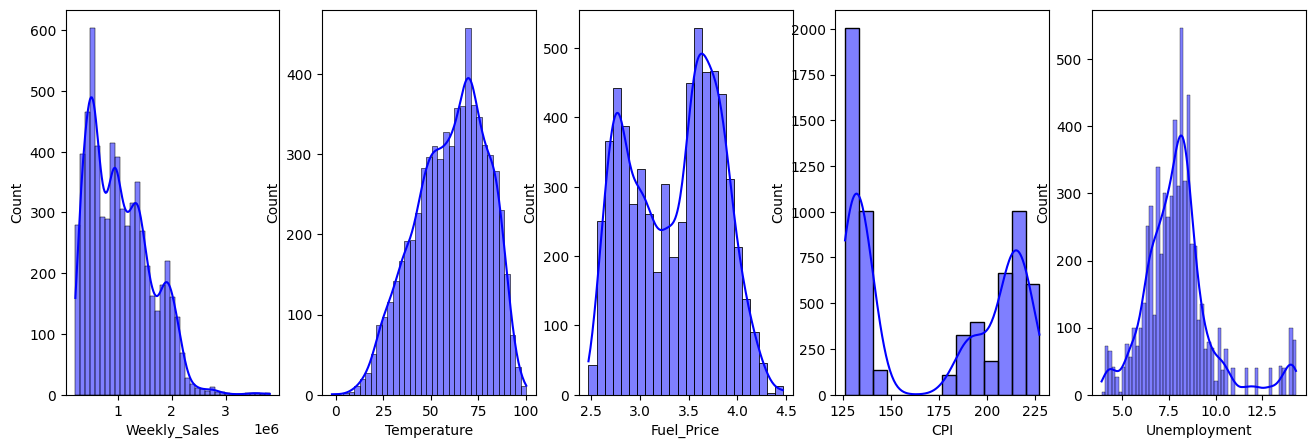

In [243]:
# Numeric features
columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i, col in enumerate(columns):
    sns.histplot(
        data=df,
        x=col,
        ax=ax[i],
        kde=True,
        color = 'blue'
    )
plt.show()

We can see that
- Temperature and Unemployment feature have normal distribution.
- Fuel_Price and CPI have bimodal distribution.
- Weekly_Sales is right skewed.

Now, let's see if there are outliers for feaatures. 

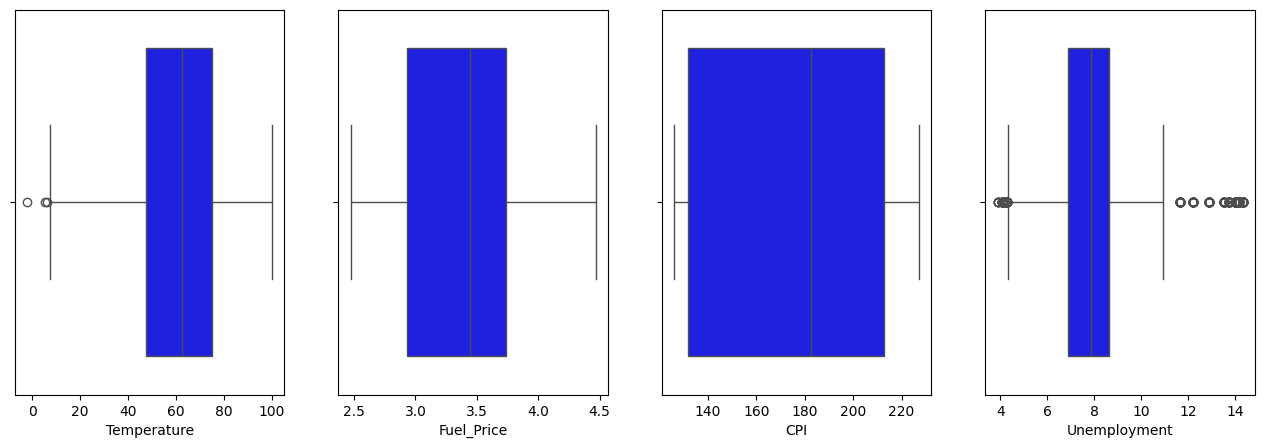

In [244]:
columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig, ax = plt.subplots(1, 4, figsize = (16,5))
for i, col in enumerate(columns):
    sns.boxplot(
        data=df,
        x = col,
        ax = ax[i],
        color = 'blue'
    )
plt.show()

As we can see, there are outliers for Temperature and Unemployment feature. Let us see how other categorical features are distributed.

In [245]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,3
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010,3
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010,3
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010,3
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010,0


In [246]:
print(df['Season'].value_counts())

Season
1    1800
0    1755
2    1530
3    1350
Name: count, dtype: int64


In [247]:
print(df['Year'].value_counts())
print(df['Month'].value_counts())

Year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64
Month
4     630
7     630
3     585
6     585
8     585
9     585
10    585
2     540
5     540
12    450
11    360
1     360
Name: count, dtype: int64


As we can see, there are less records in winters.

4. Bivariate analysis

In this section, we will see how each feature affects on the target variable. First, we will 

<Axes: xlabel='Season', ylabel='Weekly_Sales'>

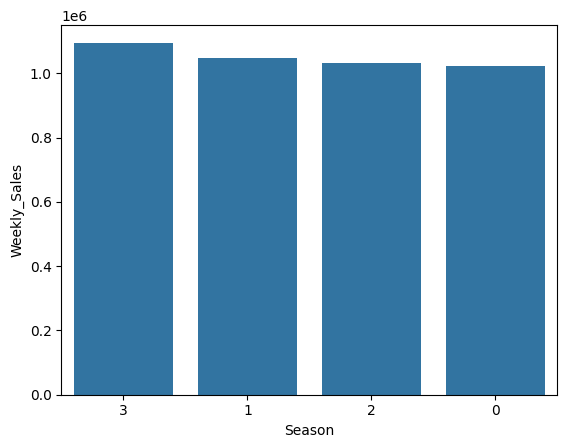

In [248]:
index_season = df.groupby('Season')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Season',
    y = 'Weekly_Sales',
    order = index_season,
    errorbar = None,
    estimator=np.mean
)

<Axes: xlabel='Year', ylabel='Weekly_Sales'>

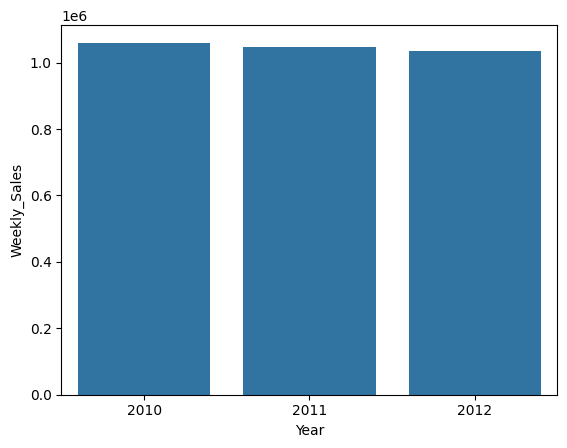

In [249]:
index_year = df.groupby('Year')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Year',
    y = 'Weekly_Sales',
    order = index_year,
    errorbar = None,
    estimator=np.mean
)

<Axes: xlabel='Month', ylabel='Weekly_Sales'>

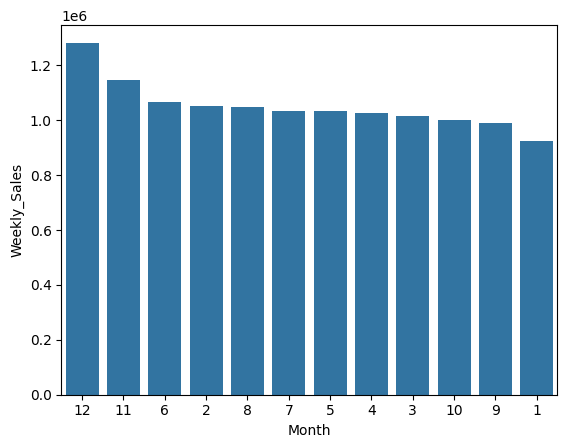

In [250]:
index_month = df.groupby('Month')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Month',
    y = 'Weekly_Sales',
    order = index_month,
    errorbar = None,
    estimator=np.mean
)

We can see that the sales in December and November is high.

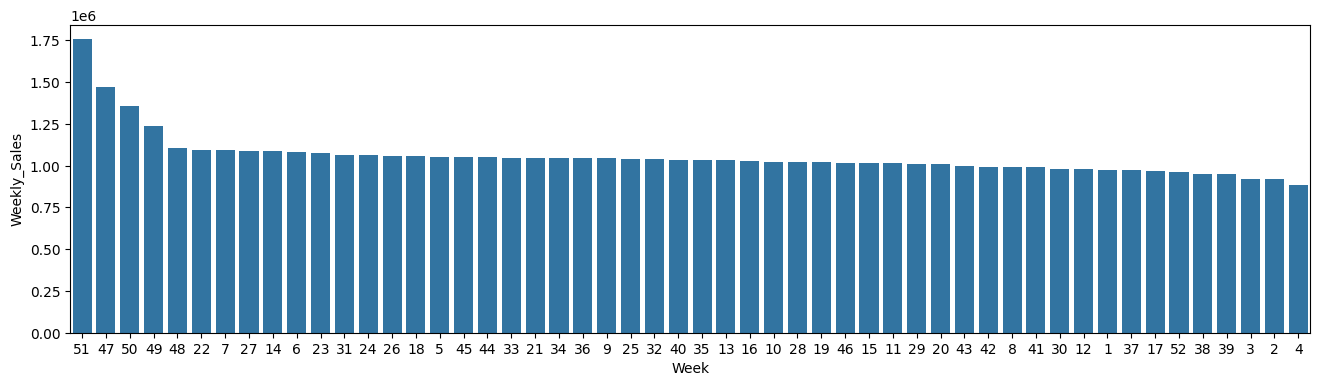

In [251]:
plt.figure(figsize = (16, 4))
index_day = df.groupby('Week')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Week',
    y = 'Weekly_Sales',
    order = index_day,
    errorbar = None,
    estimator=np.mean
)
plt.show()

We can see that the weekly sales on the end of the year is higher than other weeks.

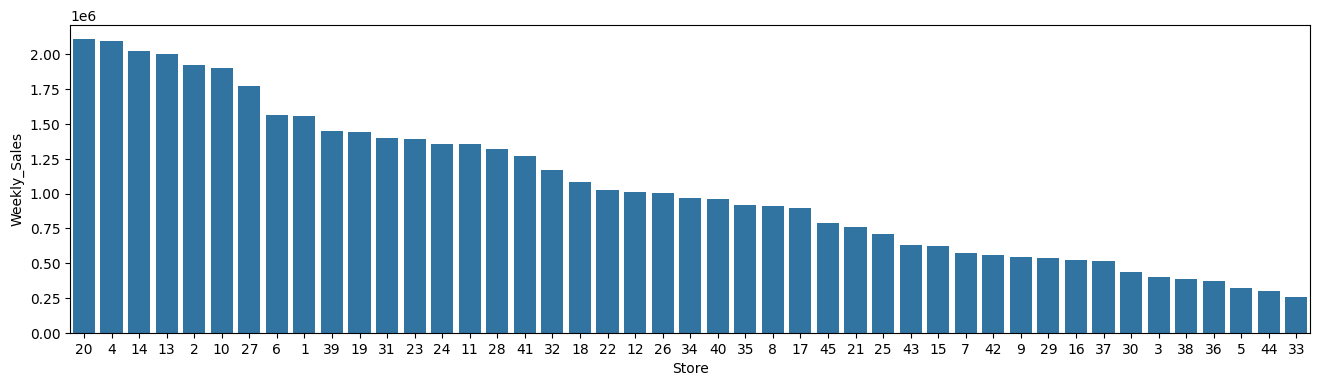

In [252]:
plt.figure(figsize=(16,4))
index_store = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Store',
    y = 'Weekly_Sales',
    order = index_store,
    errorbar = None,
    estimator=np.mean
)
plt.show()

As we can see, the sales depend on the store number. Next, let's see if the sales in holiday is higher than usual.

<Axes: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

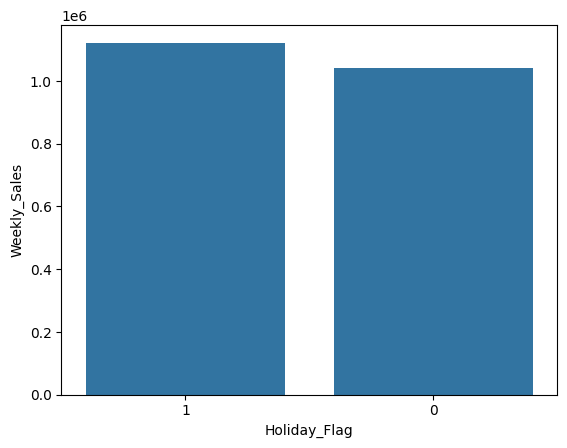

In [253]:
index_holiday = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().sort_values(ascending=False).index
sns.barplot(
    data = df,
    x = 'Holiday_Flag',
    y = 'Weekly_Sales',
    order = index_holiday,
    errorbar = None,
    estimator=np.mean
)

Now, let's move to continuous features. They are Temperature, Fuel_Price, CPI and Unemployment.

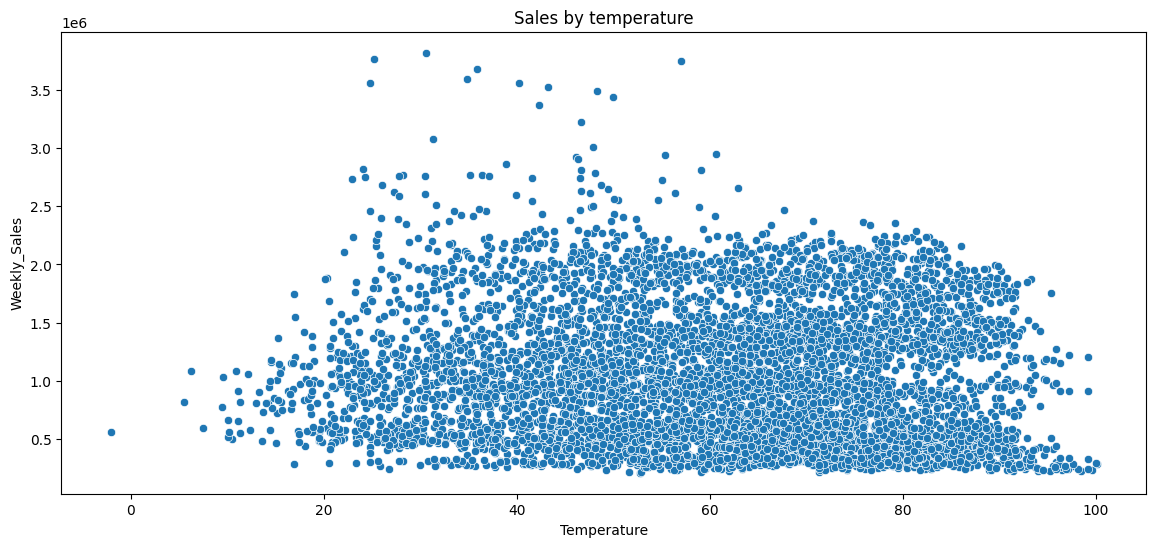

In [254]:
plt.figure(figsize = (14,6))
sns.scatterplot(
    data = df,
    x = 'Temperature',
    y = 'Weekly_Sales',
)
plt.title('Sales by temperature')
plt.show()

We can see that sales are high when the temperature is around 20-60 degree. It is less when the temperature is too low or too high.

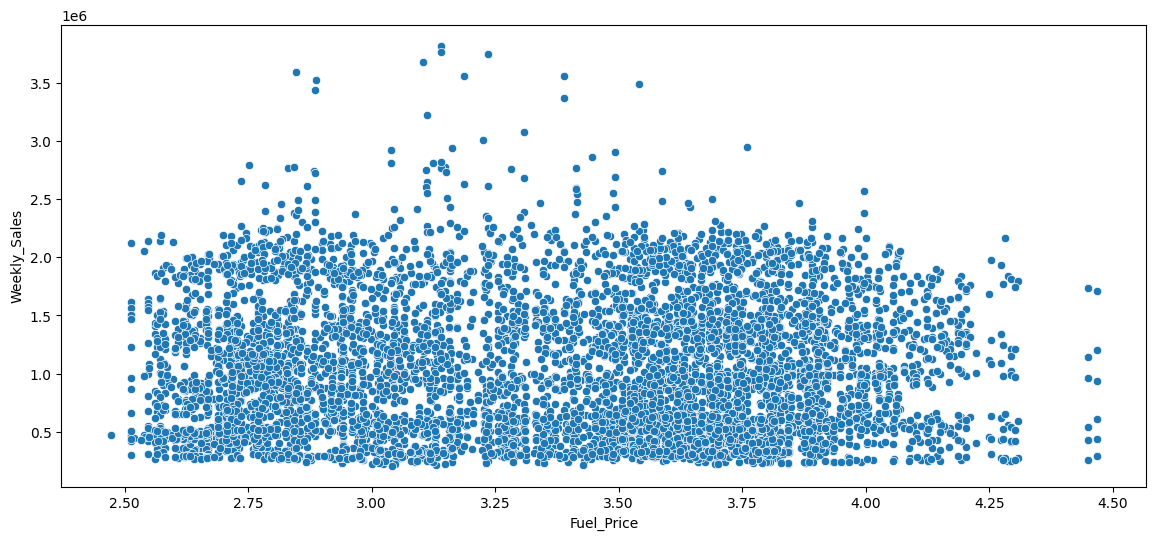

In [255]:
plt.figure(figsize = (14, 6))
sns.scatterplot(
    data = df,
    x = 'Fuel_Price',
    y = 'Weekly_Sales'
)
plt.show()

Again, we can see that sales are high when the fuel price is around 2.75 to 3.6. It tends to be less when the fuel price is higher or less.

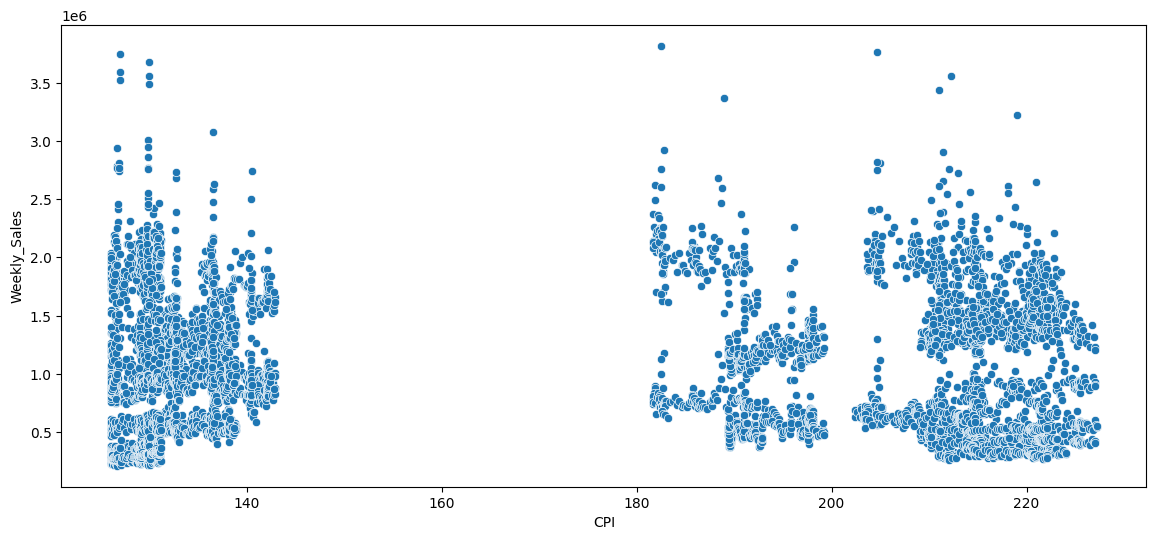

In [256]:
plt.figure(figsize = (14, 6))
sns.scatterplot(
    data = df,
    x = 'CPI',
    y = 'Weekly_Sales'
)
plt.show()

It is hard to say how CPI affects on sales, because the affects of CPI is not easy to see in such a short time.

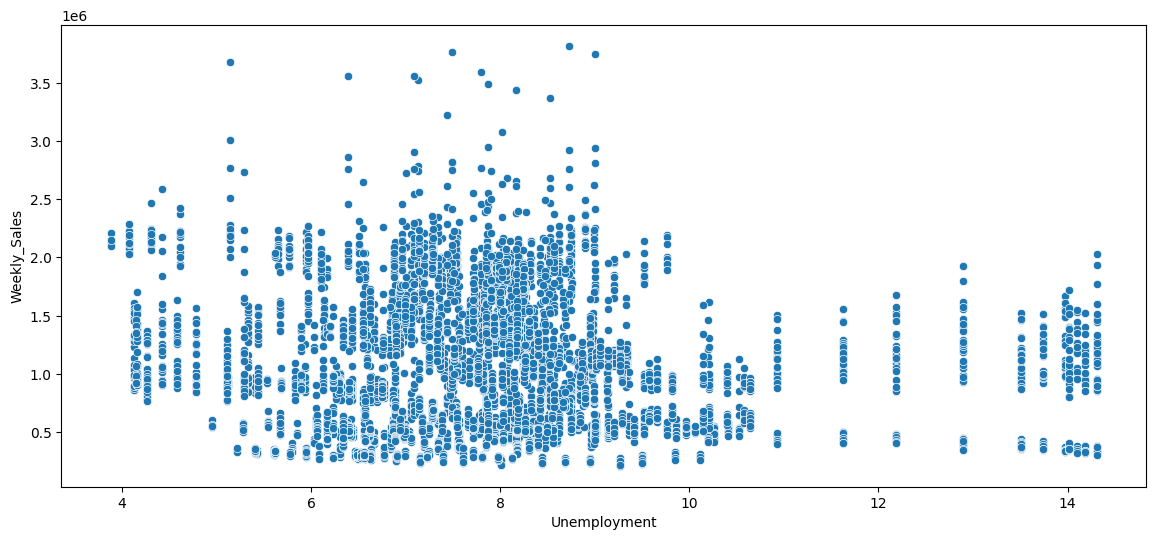

In [257]:
plt.figure(figsize = (14, 6))
sns.scatterplot(
    data = df,
    x = 'Unemployment',
    y = 'Weekly_Sales'
)
plt.show()

From the figure, we can see that sales tend to be higher when unemployment rate is in the middle, from 5.5 to 10.

5. Time series analysis

In this section, we will see how our features change over time.

In [258]:
years = ['2010', '2011', '2012']
colors = ['red', 'blue', 'green']

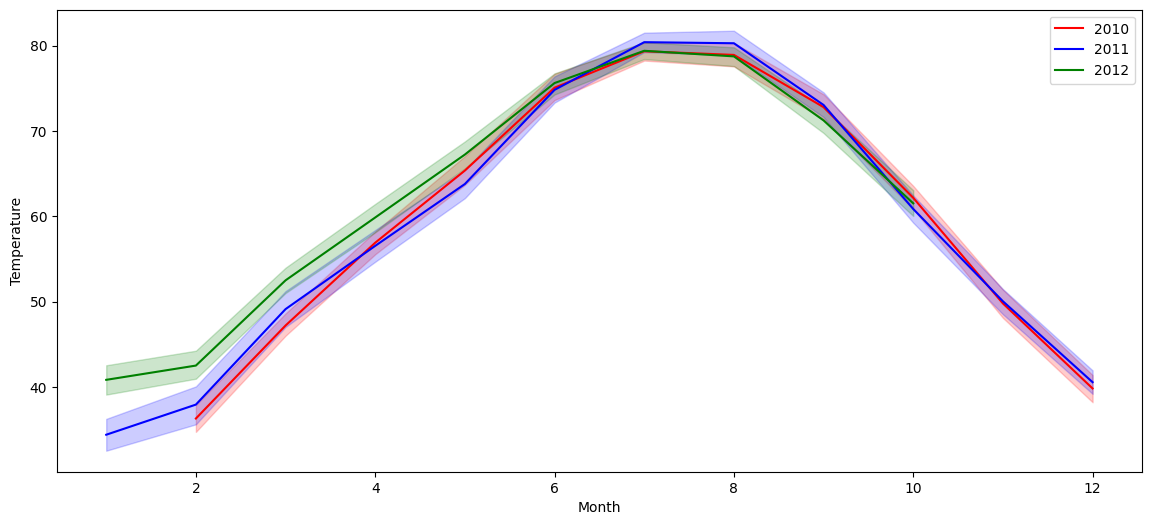

In [259]:
plt.figure(figsize = (14, 6))
for i, year in enumerate(years):
    sns.lineplot(
        data = df[df['Year'] == int(year)],
        x = 'Month',
        y = 'Temperature',
        estimator = np.mean,
        color = colors[i],
        label = year
    )
plt.show()

We can see that the temperature over 3 years don't change much.

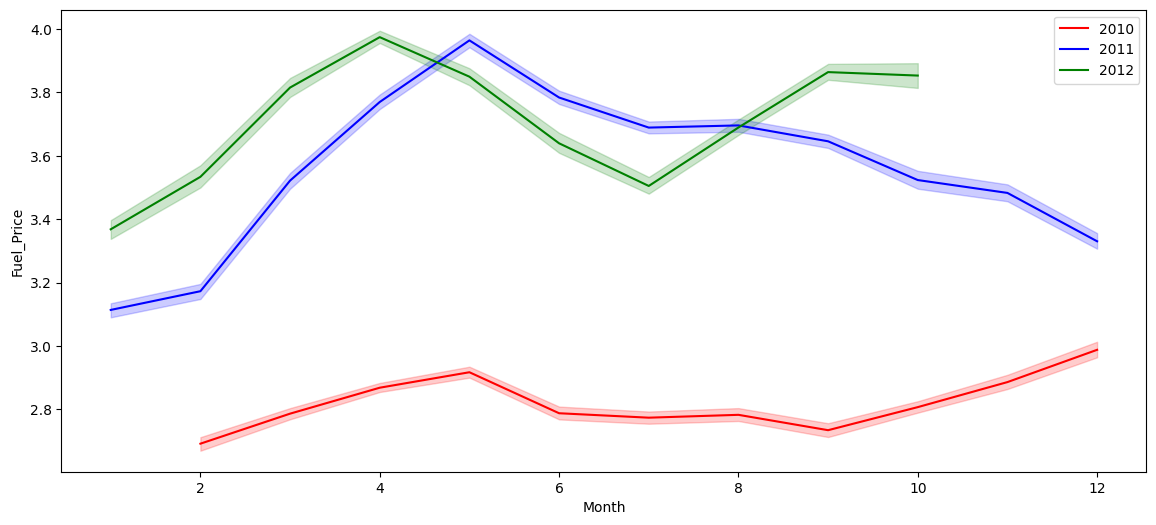

In [260]:
plt.figure(figsize = (14, 6))
for i, year in enumerate(years):
    sns.lineplot(
        data = df[df['Year'] == int(year)],
        x = 'Month',
        y = 'Fuel_Price',
        estimator = np.mean,
        color = colors[i],
        label = year
    )
plt.show()

From the figure, we can see that the fuel price in 2010 is less than in 2011 and 2012.

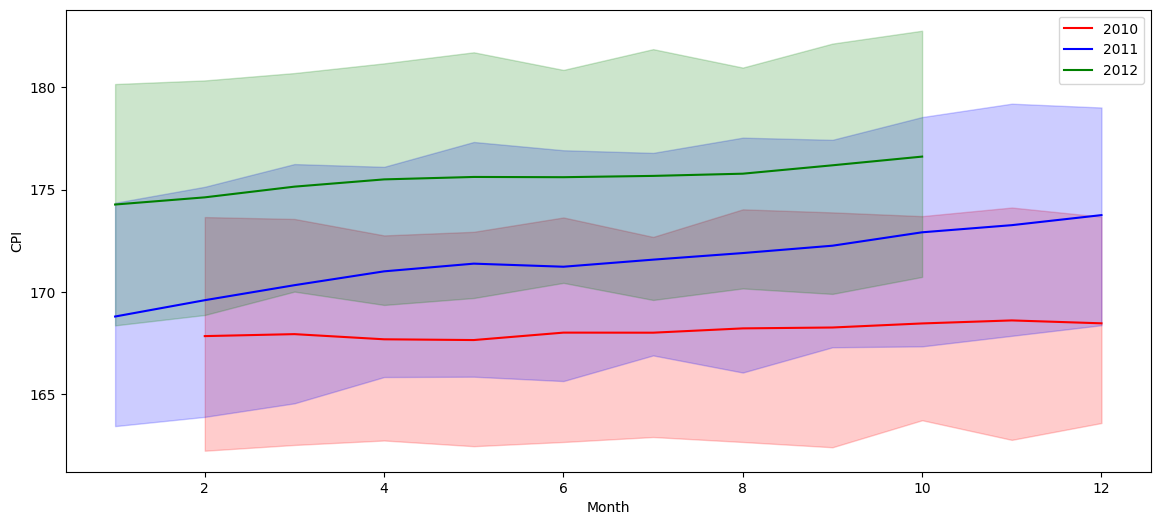

In [261]:
plt.figure(figsize = (14, 6))
for i, year in enumerate(years):
    sns.lineplot(
        data = df[df['Year'] == int(year)],
        x = 'Month',
        y = 'CPI',
        estimator = np.mean,
        color = colors[i],
        label = year
    )
plt.show()

Also, the CPI over years are increasing and it tends to slightly increase over months.

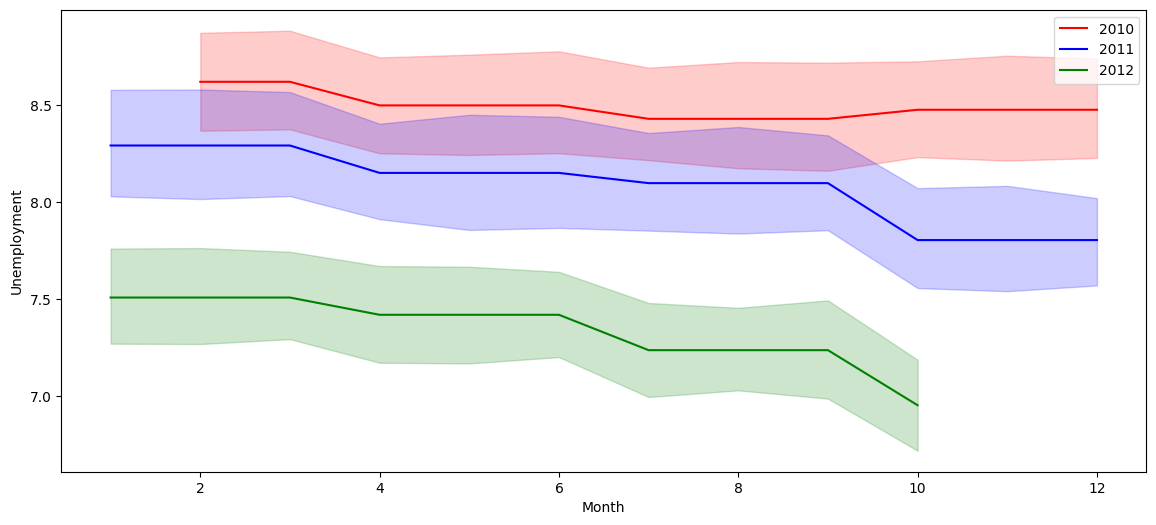

In [262]:
plt.figure(figsize = (14, 6))
for i, year in enumerate(years):
    sns.lineplot(
        data = df[df['Year'] == int(year)],
        x = 'Month',
        y = 'Unemployment',
        estimator = np.mean,
        color = colors[i],
        label = year
    )
plt.show()

The unemployment rate is decreasing over time.

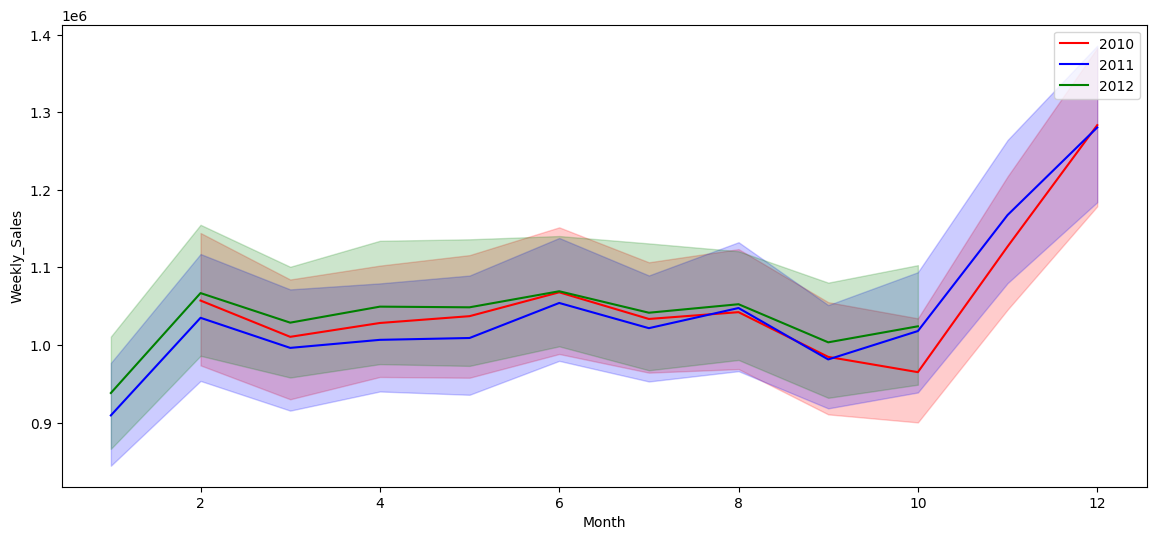

In [263]:
plt.figure(figsize = (14, 6))
for i, year in enumerate(years):
    sns.lineplot(
        data = df[df['Year'] == int(year)],
        x = 'Month',
        y = 'Weekly_Sales',
        estimator = np.mean,
        color = colors[i],
        label = year
    )
plt.show()

From the chart, the mean of weekly sales in a period of time over 3 years do not change much, and it is higher at the end of the years. Let's see if the total sales change. 

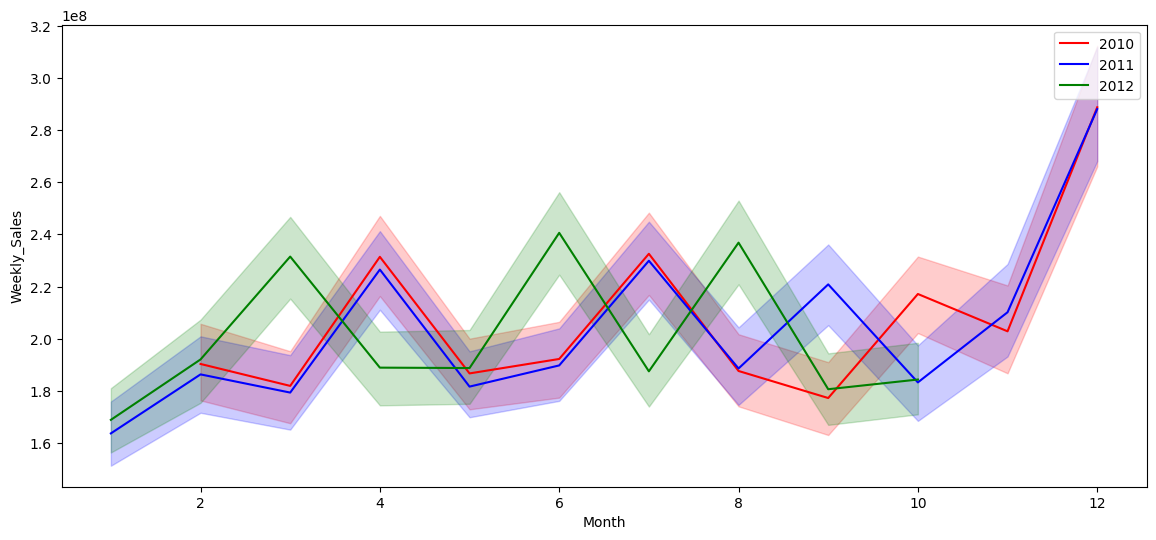

In [264]:
plt.figure(figsize = (14, 6))
for i, year in enumerate(years):
    sns.lineplot(
        data = df[df['Year'] == int(year)],
        x = 'Month',
        y = 'Weekly_Sales',
        estimator = np.sum,
        color = colors[i],
        label = year
    )
plt.show()

The total sales per month of the year 2010 and 2011 are pretty much the same, but 2012 is different. This may come from the change of CPI, unemployment rate and fuel price.

6. Correlations.

In this section, we will see the correlations between features and the target variable. We will first use Pearson's correlations.

In [265]:
columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']
corr_matrix = df[columns].corr()
print(corr_matrix)

              Temperature  Fuel_Price       CPI  Unemployment  Weekly_Sales
Temperature      1.000000    0.144982  0.176888      0.101158     -0.063810
Fuel_Price       0.144982    1.000000 -0.170642     -0.034684      0.009464
CPI              0.176888   -0.170642  1.000000     -0.302020     -0.072634
Unemployment     0.101158   -0.034684 -0.302020      1.000000     -0.106176
Weekly_Sales    -0.063810    0.009464 -0.072634     -0.106176      1.000000


Here is the plotting of this matrix.

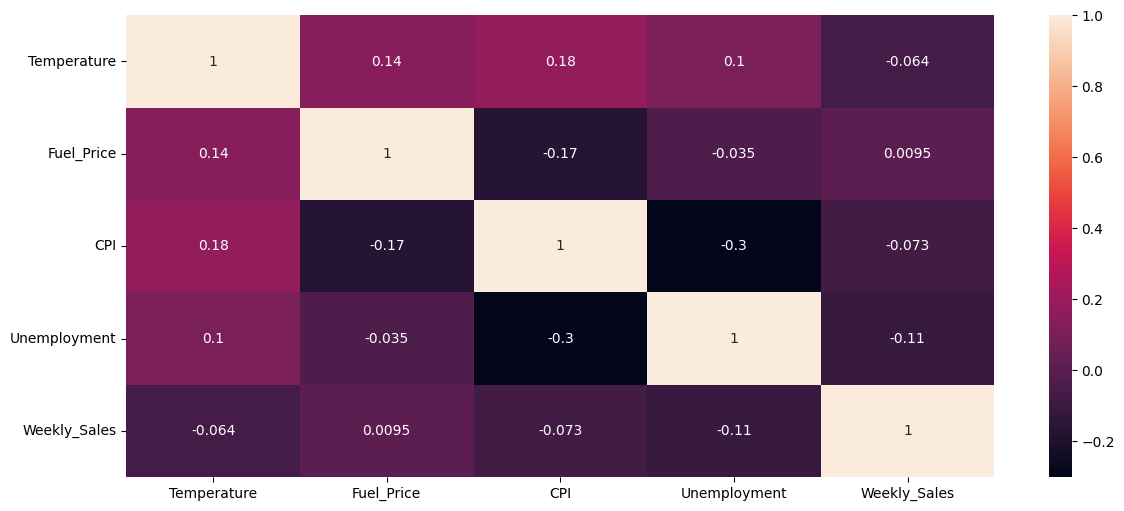

In [266]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    corr_matrix,
    annot=True
)
plt.show()

We can see that those features have weak linear relationship with the target variable. Let's try Spearman correlation to see if their relationship can be described using a monotonic function.

[[ 1.          0.12862366  0.16595652  0.03883274 -0.07096225]
 [ 0.12862366  1.         -0.04586683 -0.0647248   0.02547081]
 [ 0.16595652 -0.04586683  1.         -0.38856273 -0.05504004]
 [ 0.03883274 -0.0647248  -0.38856273  1.         -0.06235378]
 [-0.07096225  0.02547081 -0.05504004 -0.06235378  1.        ]]


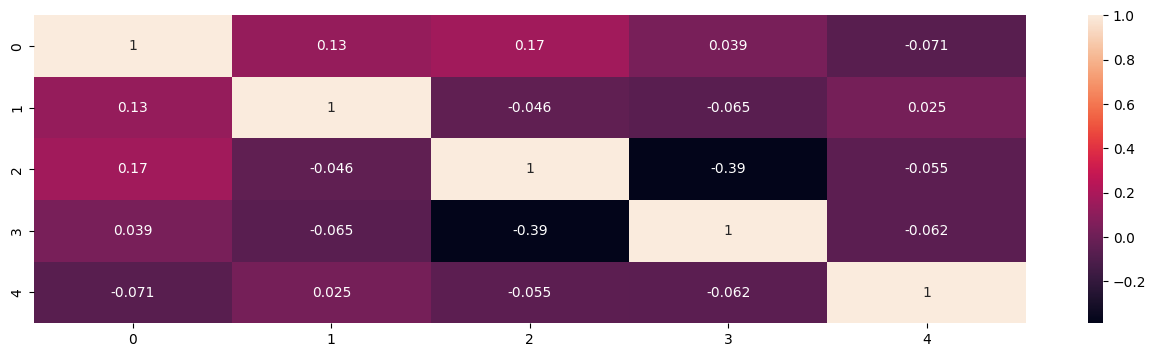

In [267]:
from scipy.stats import spearmanr

corr_matrix, _ = spearmanr(df[columns])
print(corr_matrix)
plt.figure(figsize=(16, 4))
sns.heatmap(
    corr_matrix,
    annot=True
)
plt.show()

The Spearman's correlation between the four features and the target variable is shown in the 4-th row of the matrix (indexed from 0), and those are close to 0, and this implies there are weak associations.  Let's try the Kendall's tau correlation.

In [268]:
from scipy.stats import kendalltau
temp_sale, _ = kendalltau(df['Temperature'], df['Weekly_Sales'])
fuel_sale, _ = kendalltau(df['Fuel_Price'], df['Weekly_Sales'])
cpi_sale, _ = kendalltau(df['CPI'], df['Weekly_Sales'])
unemp_sale, _ = kendalltau(df['Unemployment'], df['Weekly_Sales'])
print(temp_sale)
print(fuel_sale)
print(cpi_sale)
print(unemp_sale)

-0.04685843772514073
0.017217648163605617
-0.04171570339595327
-0.046687757699399354


These values are quite close to 0, and it suggests that the features and the output are weak associations in rank orderings. So far, we cannot say anything about the relationships between numerical features and the output, because the relationships can be described by more complex functions.

7. Remove unimportant features and outliers.

In [269]:
df_copy = df.copy()
df_copy.drop('Date', axis = 1, inplace=True)
df_copy.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year,Season
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,3
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010,3
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010,3
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010,3
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010,0


As we already saw, there are outliers of temperature and unloyment rate we need to remove.

In [270]:
# Remove outliers for unemployment feature
low_indices = df_copy[df_copy['Unemployment'] < 4.4].index
high_indices = df_copy[df_copy['Unemployment'] > 11].index
df_copy.drop(low_indices, axis=0, inplace = True)
df_copy.drop(high_indices, axis = 0, inplace = True)

In [271]:
# Remove outlier for temperature feature
lower_indices = df_copy[df_copy['Temperature'] < 5.0].index
df_copy.drop(lower_indices, axis=0, inplace=True)

Let's check if the outliers are removed.

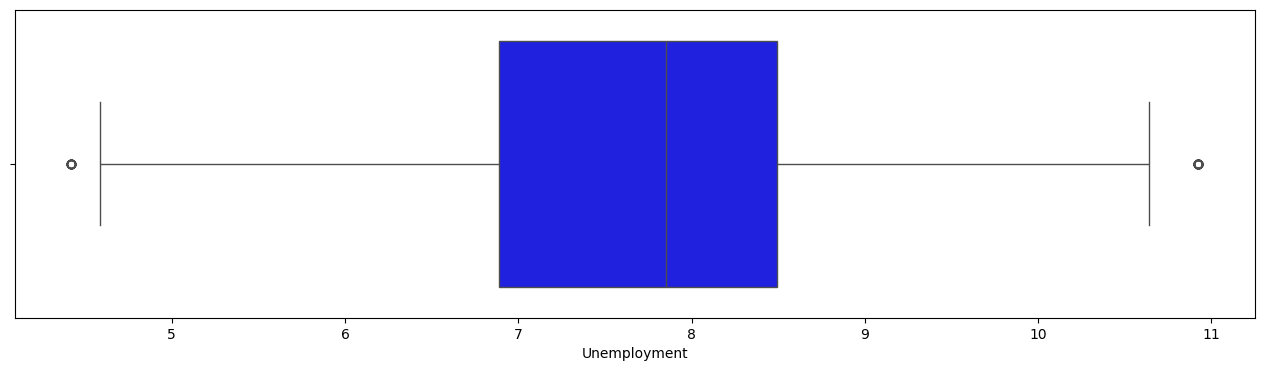

In [272]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data = df_copy,
    x = 'Unemployment',
    color = 'blue'
)
plt.show()

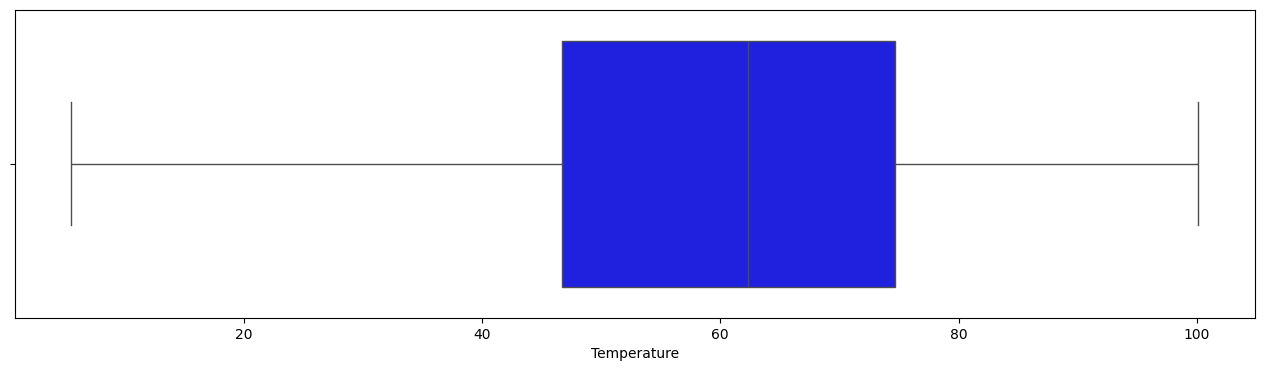

In [273]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data=df_copy,
    x = 'Temperature',
    color = 'blue'
)
plt.show()

All outliers are removed. We can prepare data for the models.

7. Data preprocessing

In [274]:
df_copy.dtypes

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Week             UInt32
Month             int32
Year              int32
Season            int64
dtype: object

We will next create X, y

In [275]:
X = df_copy.drop('Weekly_Sales', axis = 1)
y = df_copy['Weekly_Sales']

And now, we can transform continuous features of X.

In [276]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder

num_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
cat_features = ['Store', 'Holiday_Flag', 'Year', 'Month', 'Week', 'Season']
preprocessor = ColumnTransformer(
    transformers = [
        ('num_features', StandardScaler(), num_features),
        ('cat_features', BinaryEncoder(), cat_features)
    ]
)

In [277]:
X_transformed = preprocessor.fit_transform(X)

We can split the data into train and test set now.

In [278]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, shuffle=True, test_size=0.2)

Let's see the shapes of train and test set.

In [279]:
print("X_train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape", X_test.shape)
print("y test shape", y_test.shape)

X_train shape:  (4752, 10)
y train shape:  (4752,)
X test shape (1188, 10)
y test shape (1188,)


8. Additional functions for modelling

Before modelling, we will define some additional functions for model evaluation, plotting, cross validation and hypertunning.

In [280]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# This function is for model evaluation
def model_evaluation(estimator, X, y):
    predicted_values = estimator.predict(X)
    MSELoss = mean_squared_error(predicted_values, y)
    RMSELoss = np.sqrt(MSELoss)
    r2score = r2_score(predicted_values, y)
    print("RMSE loss: ", RMSELoss)
    print("R2 score: ", r2score)
    return predicted_values

# We will plot the results in a certain range
def point_plot(y_pred, y_true, title, range = 200, start_index = 0):
    plt.figure(figsize=(14,6))
    sns.pointplot(
        x = np.arange(range), 
        y = y_pred[start_index : start_index + range], 
        label = 'predicted values', 
        color = 'red'
    )
    sns.pointplot(
        x = np.arange(range),
        y = y_true[start_index : start_index + range],
        label = 'actual values',
        color = 'blue'
    )
    plt.title(title)
    plt.legend()
    plt.show()

# This function is for cross validation
def cross_validation(estimator, X, y, score = 'r2', n = 5):
    validate = cross_val_score(estimator, X, y, scoring = score, cv = n)
    print("Mean valiation R2 score: ", validate.mean())

# This is for hypertunning
def hyper_tune(estimator, X, y, param_grid, score = 'r2', n = 5):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=score,
        cv=n
    )
    grid_search.fit(X, y)
    best_score = grid_search.best_score_
    print("Best R2 score: ", best_score)
    return grid_search.best_estimator_

9. Models
In this section, we will use linear regression, decision tree, and XGBoost to see how they perform on this dataset.

In [281]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

Let's evaluate and plot the linear regression model.

RMSE loss:  77357818.83149013
R2 score:  -2015.7253171074483


c:\Users\Thuong Dang\.virtualenvs\sale_prediction_self_attention_and_classic-ozu--wyE\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


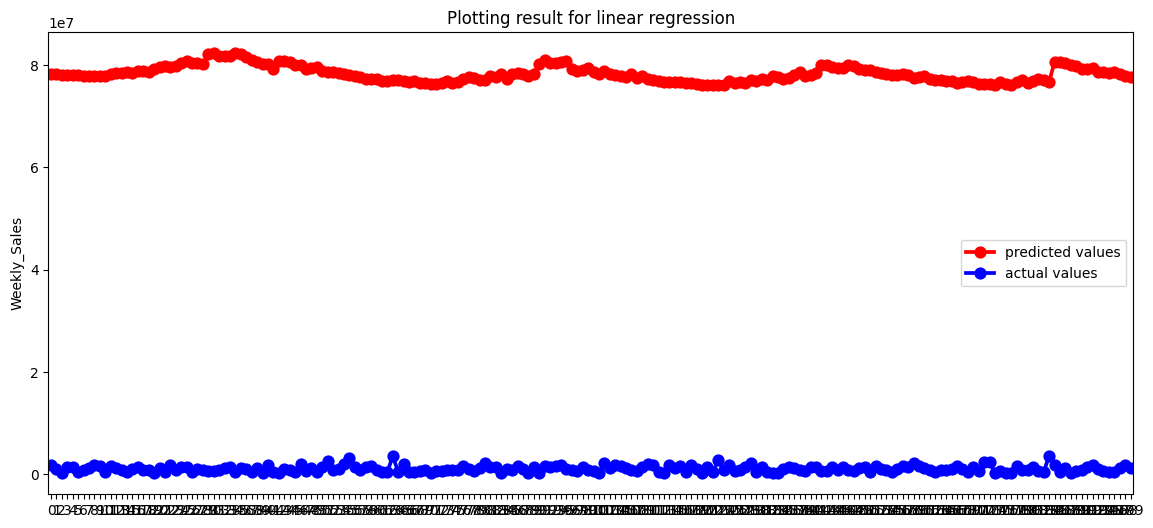

In [282]:
y_pred = model_evaluation(linear_model, X, y)
# Plot 200 values in the middle
title = 'Plotting result for linear regression'
point_plot(y_pred, y_train, title, range=200, start_index=500)

As we can see the performance is not very good. We need to hyper tune this.

In [283]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

LR_pipeline = Pipeline([
    ('poly_feat', PolynomialFeatures()),
    ('model', LinearRegression())
])
param_grid = {'poly_feat__degree': [2, 3,4]}
LR_best = hyper_tune(LR_pipeline, X_train, y_train, param_grid)

Best R2 score:  0.576176555739026


As we can see, the R2 score is improved, let's plot this.

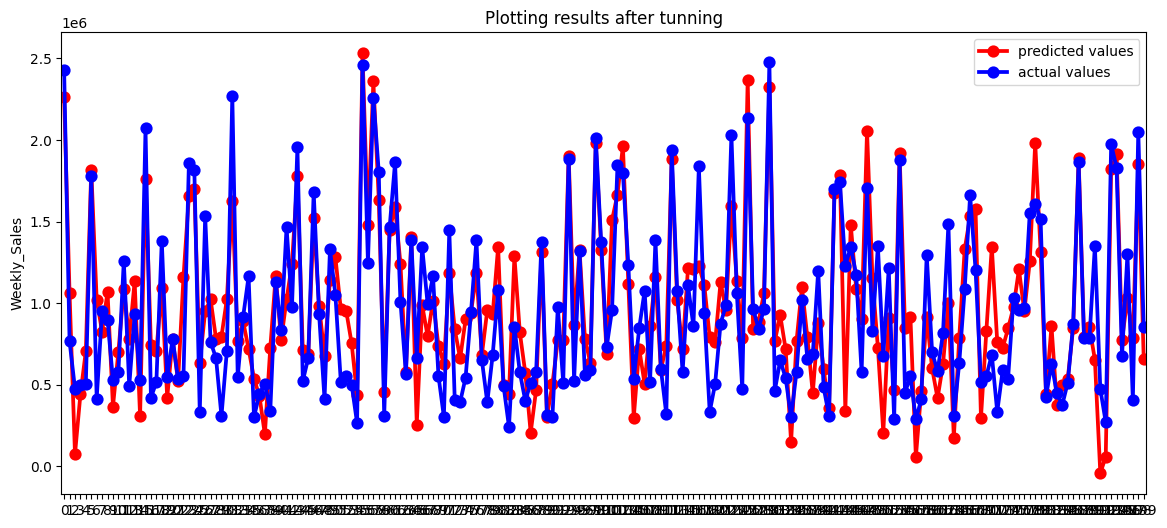

In [284]:
y_pred = LR_best.predict(X_train)
title = 'Plotting results after tunning'
point_plot(y_pred, y_train, title)

It looks much better now. Let's now try decision tree.

RMSE loss:  0.0
R2 score:  1.0


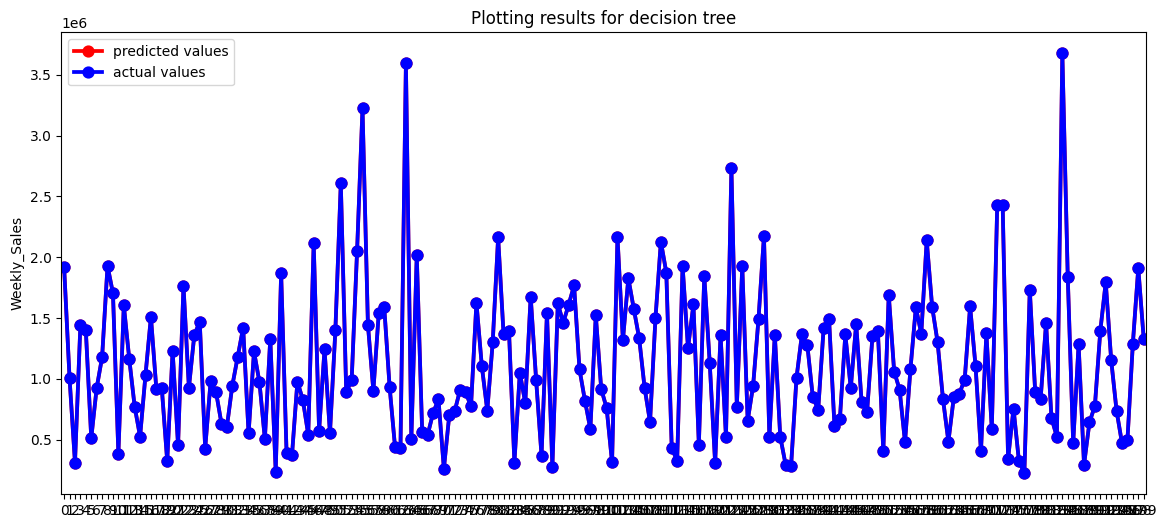

In [285]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred = model_evaluation(tree, X_train, y_train)
title = 'Plotting results for decision tree'
point_plot(y_pred, y_train, title, range = 200, start_index=500)

This is overfitting and we would need hypertunning.

Best R2 score:  0.86281648534545
RMSE loss:  197739.17484370523
R2 score:  0.8657954237571175


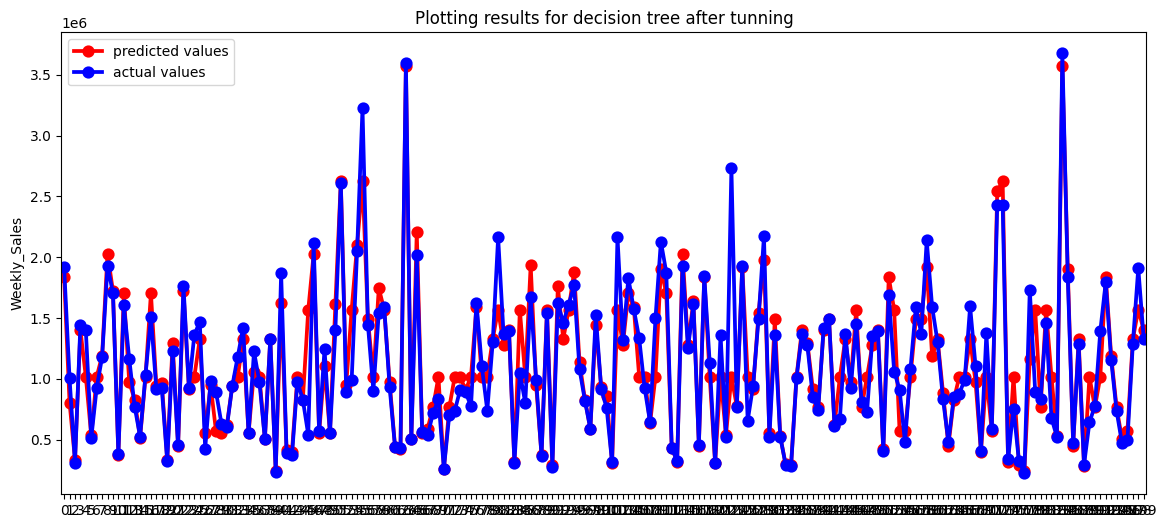

In [286]:
param_grid = {
    'max_depth': np.arange(1,10),
    'min_samples_split': [10, 20, 30, 50, 100, 200]
}
best_tree = hyper_tune(tree, X_train, y_train, param_grid)
y_pred = model_evaluation(best_tree, X_train, y_train)
title = 'Plotting results for decision tree after tunning'
point_plot(y_pred, y_train, title, range=200, start_index=500)

As we can see, it is not overfitting anymore. Let's see how it perform on the test set.

RMSE loss:  185806.8091336948
R2 score:  0.8792693015325708


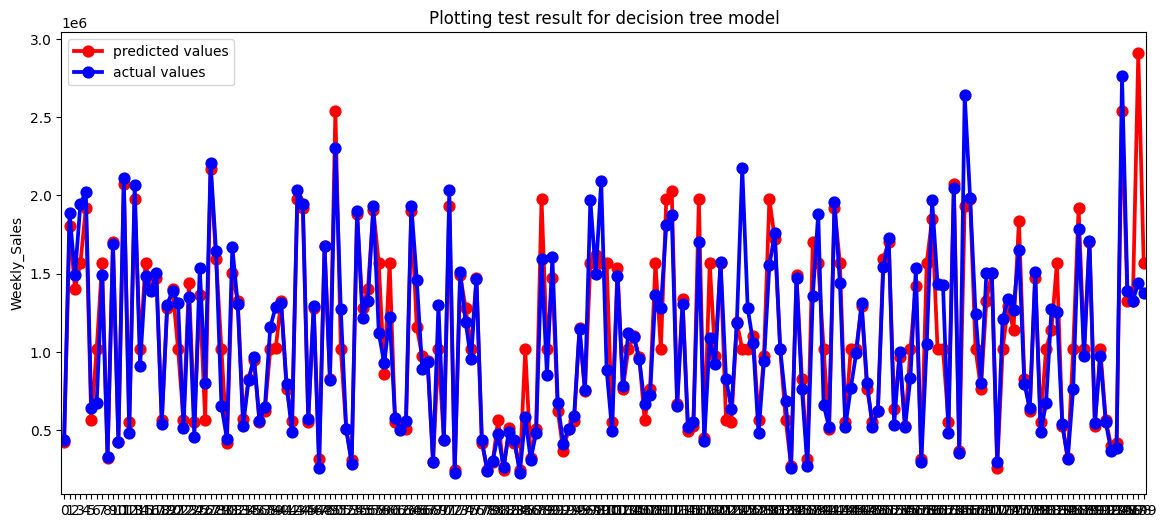

In [287]:
y_pred = model_evaluation(best_tree, X_test, y_test)
title = 'Plotting test result for decision tree model'
point_plot(y_pred, y_test, title, range = 200, start_index = 500)

This is quite a good result. Let's try XGBoost model.

RMSE loss:  29511.479667098
R2 score:  0.997332402999738


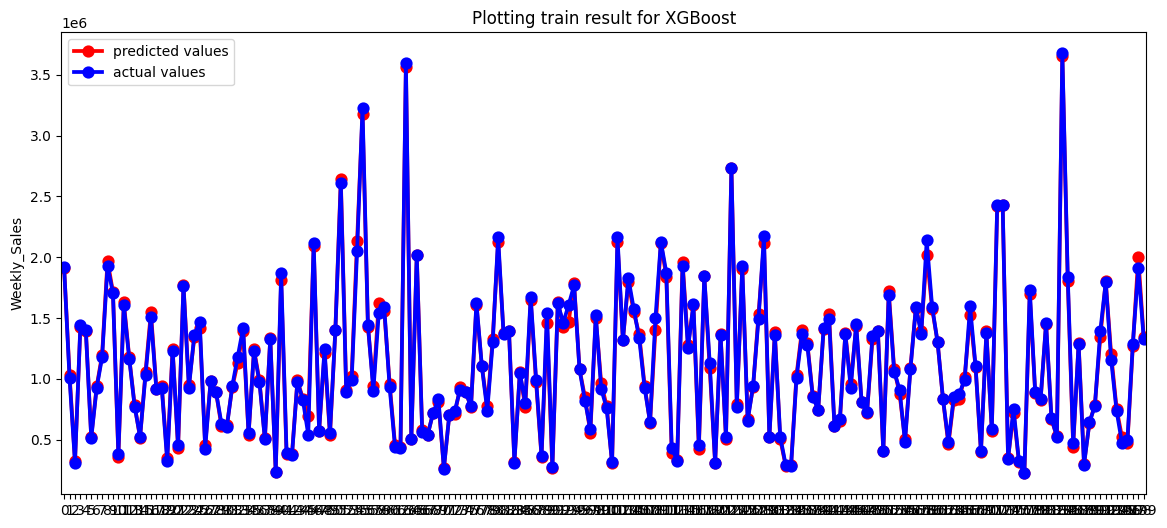

In [288]:
from xgboost import XGBRegressor
xg_boost = XGBRegressor()
xg_boost.fit(X_train, y_train)
y_pred = model_evaluation(xg_boost, X_train, y_train)
title = 'Plotting train result for XGBoost'
point_plot(y_pred, y_train, title, range=200, start_index=500)

Let's check its validation score to see if we are overfitting.

In [289]:
cross_validation(xg_boost, X_train, y_train)

Mean valiation R2 score:  0.9776577135794579


That seems fine, let's try the model on our test set.

RMSE loss:  83621.77874733358
R2 score:  0.9762525366629266


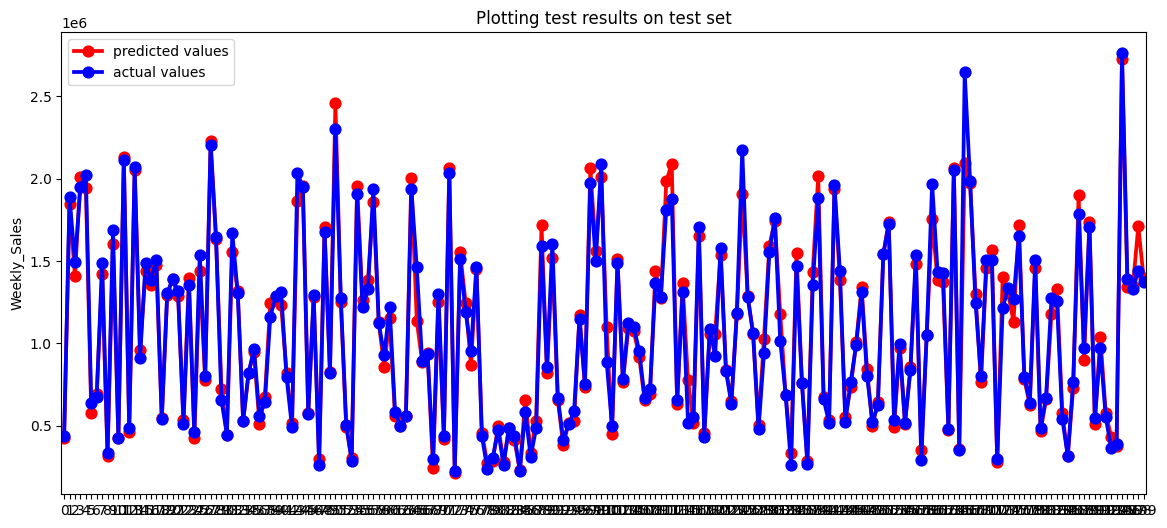

In [290]:
y_pred = model_evaluation(xg_boost, X_test, y_test)
title = 'Plotting test results on test set'
point_plot(y_pred, y_test, title, range = 200, start_index=500)

10. Conclusion.

XGBoost is the best model on this dataset with R2 scores 99.76% on training set, 97.76% mean validation score, and 97.6% on test set.